# Tarea 2 : Clasificación y búsqueda por similitud de sketches usando redes convolucionales

# CC6204 Deep Learning, Universidad de Chile <br/> Hoja de respuestas 

## Nombre: Martín Cornejo Saavedra
Fecha para completar la tarea: 17 de junio de 2018

In [0]:
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
from google.colab import files
creds = GoogleCredentials.get_application_default()
import getpass
# Work around misordering of STREAM and STDIN in Jupyter.
# https://github.com/jupyter/notebook/issues/3159
prompt = !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass(prompt[0] + '\n\nEnter verification code: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print 'Files in Drive:'
#!ls drive/

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from skimage.draw import line as drawLine

import pdb
import random
import os
import json

In [107]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Construcción del conjunto de datos

In [0]:
raw_categories = !gsutil ls -r "gs://quickdraw_dataset/full/simplified/*"

max_num_categories = 5
train_samples_per_cat = 100
test_samples_per_cat = 10

### Importar dataset previamente descargado (opcional)

In [0]:
!cp drive/data_quickdraw/train.tar.gz train.tar.gz 
!cp drive/data_quickdraw/test.tar.gz test.tar.gz 

In [41]:
#!tar xzf train.tar.gz
#!tar xzf test.tar.gz
!ls

compass.ndjson	drive		 guitar.ndjson	    test	 train
crayon.ndjson	dumbbell.ndjson  light bulb.ndjson  test.tar.gz  train.tar.gz


### Elegimos 100 categorias al azar y las descargamos

In [0]:
for idx, raw_cat in enumerate(raw_categories):
  raw_categories[idx] = raw_cat.replace(" ", "\ ")   # para que bash reconozca el espacio en la descarga

random_categories = []

while True:
  rand_cat = random.randint(0, len(raw_categories)-1)
  if rand_cat not in random_categories:
    random_categories.append(rand_cat)
  if len(random_categories) is max_num_categories:
    break

In [0]:
#!mkdir quick_draw_data
#os.chdir("/content/quick_draw_data")
#!mkdir training

snapshot_path = "./training/snap.ckpt"

In [0]:
str_random_cat = []

os.system("mkdir train")
os.system("mkdir test")

for category in random_categories:
  aux = raw_categories[category].replace("gs://quickdraw_dataset/full/simplified/", "")
  aux = aux.replace(".ndjson", "")
  str_random_cat.append(aux)

In [9]:
for idx, category in enumerate(random_categories):
  os.system("gsutil cp " + raw_categories[category] + " .")
  print("La categoria " + str(idx+1) + " copiada es " + raw_categories[category])

La categoria 1 copiada es gs://quickdraw_dataset/full/simplified/donut.ndjson
La categoria 2 copiada es gs://quickdraw_dataset/full/simplified/fan.ndjson
La categoria 3 copiada es gs://quickdraw_dataset/full/simplified/blackberry.ndjson
La categoria 4 copiada es gs://quickdraw_dataset/full/simplified/helmet.ndjson
La categoria 5 copiada es gs://quickdraw_dataset/full/simplified/airplane.ndjson


In [10]:
categories = !ls
print(len(categories))

for cat in str_random_cat:
  if (cat + ".ndjson").replace("\ ", " ") not in categories:
    print("falta " + cat)

8


### Se convierte la data en formato json a bitmaps de 128x128 y se guardan en formato .txt

In [0]:
def parse_line(ndjson_line):
  """Parse an ndjson line and return ink (as np array) and classname."""
  sample = json.loads(ndjson_line)
  class_name = sample["word"]
  if not class_name:
    print ("Empty classname")
    return None, None
  inkarray = sample["drawing"]

  div_scale = 2
  
  for idx, stroke in enumerate(inkarray):
    if len(stroke[0]) != len(stroke[1]):
      print("Inconsistent number of x and y coordinates.")
      return None, None
    
    for idy, x_coord in enumerate(stroke[0]):
      inkarray[idx][0][idy] /= div_scale
      inkarray[idx][1][idy] /= div_scale
  
  return inkarray, class_name

def convert_data(trainingdata_dir,
                 observations_per_class,
                 output_folder,
                 offset=0):
  
  file_handles = []
  # Open all input files.
  for filename in sorted(tf.gfile.ListDirectory(trainingdata_dir)):
    if not filename.endswith(".ndjson"):
      #print("Skipping", filename)
      continue
    file_handles.append(
        tf.gfile.GFile(os.path.join(trainingdata_dir, filename), "r"))
    if offset:  # Fast forward all files to skip the offset.
      count = 0
      for _ in file_handles[-1]:
        count += 1
        if count == offset:
          break

    
  reading_order = list(range(len(file_handles)))
          
  class_names = []  
  class_names_pairs = []
    
  for idx in reading_order:
    for pictureNum in range(observations_per_class):
      line = file_handles[idx].readline()
      ink = None
      
      while ink is None:
        ink, class_name = parse_line(line)
        if ink is None:
          print ("Couldn't parse ink from '" + line + "'.")

      drawing = np.zeros((128, 128), dtype=np.uint8)
      
      if class_name not in class_names:
        class_names.append(class_name)  
        class_names_pairs.append((idx, class_name))      
        os.system("mkdir " + output_folder + str(idx))
        print(str(idx) + ";" + class_name)

      for linea in ink:
        for idy in range(len(linea[0])-1):
          rr, cc = drawLine(linea[1][idy], linea[0][idy], linea[1][idy+1], linea[0][idy+1])
          drawing[rr, cc] = 1

      np.savetxt(output_folder + str(idx) + "/" + str(pictureNum) + ".txt", drawing, fmt="%d", delimiter=" ")
#       file = drive.CreateFile({'parents':[{u'id': folder_id}]})
#       file.SetContentFile(output_folder + str(idx) + "/" + str(pictureNum) + ".txt")
#       file['title'] = str(pictureNum) + ".txt"
#       file.Upload()

  return class_names_pairs

In [16]:
class_names_train = convert_data(".",
             train_samples_per_cat,
             "train/")

0;airplane
1;blackberry
2;donut
3;fan
4;helmet


In [17]:
class_names_test = convert_data(".",
             test_samples_per_cat,
             "test/",
             train_samples_per_cat)

0;airplane
1;blackberry
2;donut
3;fan
4;helmet


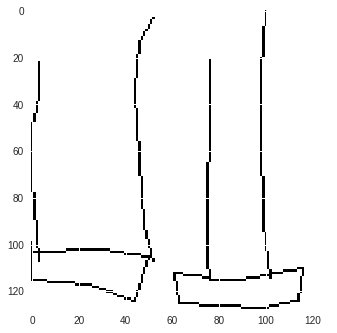

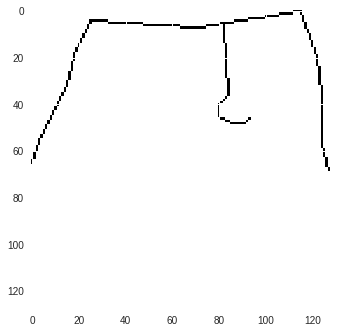

In [14]:
test_imagen = np.loadtxt("test/3/9.txt")
plt.imshow(test_imagen)
plt.show()

train_imagen = np.loadtxt("train/3/99.txt")
plt.imshow(train_imagen)
plt.show()

### Descargar Dataset

In [0]:
!tar czf train.tar.gz train/
!tar czf test.tar.gz test/
files.download('train.tar.gz') 
files.download('test.tar.gz') 

### Se crea una clase para extraer datos de entrenamiento

In [0]:
class QuickDataset():
  def __init__(self, data_path, samples_per_cat):            
    self.samples = samples_per_cat
    self.data_path = data_path + "/"    
  
  def get_batch(self, batch_size):
    x_lista = []
    y_lista = []    
    
    for _ in range(batch_size):
      cat = np.random.randint(max_num_categories)
      sample = np.random.randint(self.samples)
      
      train_input = np.loadtxt(self.data_path + str(cat) + "/" + str(sample) + ".txt")
      x_lista.append(np.resize(train_input, (1, 16384))[0])
      y_lista.append(cat)
  
    return x_lista, y_lista
    
train_dataset = QuickDataset("train", train_samples_per_cat)
test_dataset = QuickDataset("test", test_samples_per_cat)

### Función de entrenamiento

In [0]:
def train_net(dnn_graph, batch_size, n_epochs, learning_rate, loadPrev = False):
  
  x = tf.placeholder(tf.float16, shape=(None, 128*128))
  y_ = tf.placeholder(tf.int64, shape=(None))
  y_conv = dnn_graph(x, True)
  
  with tf.name_scope('accurracy'):
  
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_,
                                                              logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)

    train_step = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = train_step.minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

  loss_array = []
  train_acc = []
  test_acc = []
  
  batches_per_epoch = max_num_categories * train_samples_per_cat / batch_size
  
  test_batches_per_epoch = max_num_categories * test_samples_per_cat / batch_size
  
  with tf.Session() as sess:              
    
    if loadPrev:
      reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                     scope="conv[12345678]") 
      reuse_vars += tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                     scope="dense[12]")       
      reuse_vars += tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                     scope="convb[12345678]") 
      pdb.set_trace()
      reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
      saver = tf.train.Saver(reuse_vars_dict)
      saver.restore(sess, snapshot_path)
    else:     
      init = tf.global_variables_initializer()
      saver = tf.train.Saver()
      init.run()   
    
    for idz in range(n_epochs * batches_per_epoch):
      batch = train_dataset.get_batch(batch_size)
        
      if idz % (batches_per_epoch/5) == 0:
        train_accuracy = accuracy.eval(session=sess, feed_dict={x: batch[0], y_: batch[1]})
        print('step %d, training set accuracy %g' % (idz, train_accuracy))
        loss_array.append(cross_entropy.eval(feed_dict={x: batch[0], y_: batch[1]}))
        train_acc.append(train_accuracy)

      if idz % batches_per_epoch == 0 and idz > 0:        
        test_acc_aux = []
        for idy in range(test_batches_per_epoch): 
          test_batch = test_dataset.get_batch(batch_size)
          test_acc_aux.append(accuracy.eval(feed_dict={x: test_batch[0], y_: test_batch[1]}))  

        test_acc_mean = sum(test_acc_aux)/len(test_acc_aux)  
        print('test set accuracy ' + str(test_acc_mean))
        test_acc.append(test_acc_mean)
        
        saved_path = saver.save(sess, snapshot_path)

      sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})
        
  return loss_array, train_acc, test_acc

## Construcción y entrenamiento de la skNet

### Construcción del grafo

In [0]:
def skNet(x, training=False):
  with tf.name_scope('skNet'):
    x_image = tf.reshape(x, [-1, 128, 128, 1])       
 
    conv1_1 = tf.layers.conv2d(
      inputs=x_image,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      name="conv1",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv1_1_n = tf.contrib.layers.batch_norm(conv1_1,
                                      center=True,
                                      scale=True, 
                                      is_training=training,
                                            scope="convb1",
                                            reuse=tf.AUTO_REUSE)

    conv1_2 = tf.layers.conv2d(
      inputs=conv1_1_n,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      name="conv2",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv1_2_n = tf.contrib.layers.batch_norm(conv1_2,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb2",
                                            reuse=tf.AUTO_REUSE)

    pool1 = tf.layers.max_pooling2d(inputs=conv1_2_n, pool_size=[3, 3], strides=2)

    conv2_1 = tf.layers.conv2d(
      inputs=pool1,
      filters=128,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      name="conv3",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv2_1_n = tf.contrib.layers.batch_norm(conv2_1,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb3",
                                            reuse=tf.AUTO_REUSE)

    conv2_2 = tf.layers.conv2d(
        inputs=conv2_1_n,
        filters=128,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv4",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv2_2_n = tf.contrib.layers.batch_norm(conv2_2,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb4",
                                            reuse=tf.AUTO_REUSE)

    pool2 = tf.layers.max_pooling2d(inputs=conv2_2_n, pool_size=[3, 3], strides=2)

    conv3_1 = tf.layers.conv2d(
        inputs=pool2,
        filters=128,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv5",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv3_1_n = tf.contrib.layers.batch_norm(conv3_1,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb5",
                                            reuse=tf.AUTO_REUSE)

    conv3_2 = tf.layers.conv2d(
        inputs=conv3_1_n,
        filters=128,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv6",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv3_2_n = tf.contrib.layers.batch_norm(conv3_2,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb6",
                                            reuse=tf.AUTO_REUSE)

    pool3 = tf.layers.max_pooling2d(inputs=conv3_2_n, pool_size=[3, 3], strides=2)

    conv4_1 = tf.layers.conv2d(
        inputs=pool3,
        filters=256,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv7",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv4_1_n = tf.contrib.layers.batch_norm(conv4_1,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb7",
                                            reuse=tf.AUTO_REUSE)

    conv4_2 = tf.layers.conv2d(
        inputs=conv4_1_n,
        filters=256,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv8",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv4_2_n = tf.contrib.layers.batch_norm(conv4_2,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb8",
                                            reuse=tf.AUTO_REUSE)

    pool4 = tf.layers.max_pooling2d(inputs=conv4_2_n, pool_size=[3, 3], strides=2)

    # Dense layer

    pool2_flat = tf.reshape(pool4, [-1, 7*7*256])
    dense_l = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, reuse=tf.AUTO_REUSE, name="dense1")

    # Logits Layer

    logits = tf.layers.dense(inputs=dense_l, units=max_num_categories, reuse=tf.AUTO_REUSE, name="dense2")
  
  return logits

### Entrenamiento de skNet

In [135]:
#tf.reset_default_graph()
loss_array, train_acc, test_acc = train_net(skNet, 50, 2, 0.01, True)

> <ipython-input-132-826788b14838>(38)train_net()
-> reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
(Pdb) c
INFO:tensorflow:Restoring parameters from ./training/snap.ckpt
step 0, training set accuracy 0.92
step 2, training set accuracy 0.8
step 4, training set accuracy 0.92
step 6, training set accuracy 0.88
step 8, training set accuracy 0.96
step 10, training set accuracy 0.96
test set accuracy 0.8799999952316284
step 12, training set accuracy 0.92
step 14, training set accuracy 0.96
step 16, training set accuracy 0.94
step 18, training set accuracy 0.92


In [112]:
!ls training

checkpoint  snap.ckpt.data-00000-of-00001  snap.ckpt.index  snap.ckpt.meta


ValueError: ignored

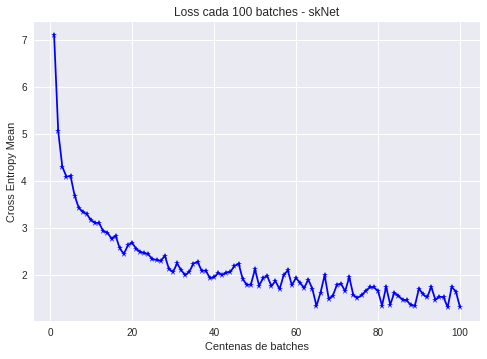

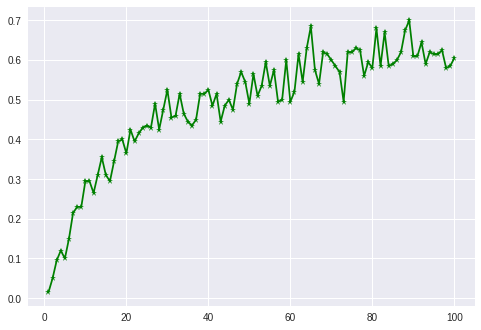

In [50]:
x_axis = np.linspace(1, len(loss_array), num=len(loss_array))

plt.figure()
plt.plot(x_axis, loss_array, 'b-*')
plt.title("Loss cada 100 batches - skNet")
plt.xlabel("Centenas de batches")
plt.ylabel("Cross Entropy Mean")
plt.savefig('loss.pdf')

plt.figure()
plt.plot(x_axis,train_acc, 'g-*')
plt.plot(x_axis,test_acc, 'b-*')
plt.legend(["Train", "Test"])
plt.title("Accurracy - skNet")
plt.xlabel("Centenas de batches")
plt.ylabel("Accurray [%]")
plt.savefig('accurracy.pdf')

## Construcción y entrenamiento de la skResNet

### Construcción del grafo

In [0]:
def skResNet(x, training=False):
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 128, 128, 1])       

  conv1_1 = tf.layers.conv2d(
    inputs=x_image,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv1_1_n = tf.contrib.layers.batch_norm(conv1_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv1_2 = tf.layers.conv2d(
    inputs=conv1_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv1_2_n = tf.contrib.layers.batch_norm(conv1_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)

  pool1 = tf.layers.max_pooling2d(inputs=conv1_2_n, pool_size=[3, 3], strides=2)
  
  conv2_1 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv2_1_n = tf.contrib.layers.batch_norm(conv2_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv2_2 = tf.layers.conv2d(
    inputs=conv2_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv2_2_n = tf.contrib.layers.batch_norm(conv2_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_1 = conv2_2_n + pool1
  
  conv3_1 = tf.layers.conv2d(
    inputs=residual_1,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv3_1_n = tf.contrib.layers.batch_norm(conv3_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv3_2 = tf.layers.conv2d(
    inputs=conv3_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv3_2_n = tf.contrib.layers.batch_norm(conv3_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_2 = conv3_2_n + residual_1
  
  conv4_1 = tf.layers.conv2d(
    inputs=residual_2,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv4_1_n = tf.contrib.layers.batch_norm(conv4_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  pool2 = tf.layers.max_pooling2d(inputs=conv4_1_n, pool_size=[3, 3], strides=2)
  
  conv5_1 = tf.layers.conv2d(
    inputs=pool2,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv5_1_n = tf.contrib.layers.batch_norm(conv5_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv5_2 = tf.layers.conv2d(
    inputs=conv5_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv5_2_n = tf.contrib.layers.batch_norm(conv5_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_3 = conv5_2_n + pool2
  
  conv6_1 = tf.layers.conv2d(
    inputs=residual_3,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv6_1_n = tf.contrib.layers.batch_norm(conv6_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv6_2 = tf.layers.conv2d(
    inputs=conv6_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv6_2_n = tf.contrib.layers.batch_norm(conv6_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_4 = conv6_2_n + residual_3
  
  conv7_1 = tf.layers.conv2d(
    inputs=residual_4,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv7_1_n = tf.contrib.layers.batch_norm(conv7_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  pool3 = tf.layers.max_pooling2d(inputs=conv7_1_n, pool_size=[3, 3], strides=2)
  
  conv8_1 = tf.layers.conv2d(
    inputs=pool3,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv8_1_n = tf.contrib.layers.batch_norm(conv8_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv8_2 = tf.layers.conv2d(
    inputs=conv8_1_n,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv8_2_n = tf.contrib.layers.batch_norm(conv8_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_5 = conv8_2_n + pool3
  
  conv9_1 = tf.layers.conv2d(
    inputs=residual_5,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv9_1_n = tf.contrib.layers.batch_norm(conv9_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv9_2 = tf.layers.conv2d(
    inputs=conv9_1_n,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv9_2_n = tf.contrib.layers.batch_norm(conv9_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_6 = conv9_2_n + residual_5
  
  conv10_1 = tf.layers.conv2d(
    inputs=residual_6,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv10_1_n = tf.contrib.layers.batch_norm(conv10_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  pool4 = tf.layers.max_pooling2d(inputs=conv10_1_n, pool_size=[3, 3], strides=2)
  
  # Dense layer
  
  pool2_flat = tf.reshape(pool4, [-1, 7*7*256])
  dense_l = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  
  # Logits Layer
  
  logits = tf.layers.dense(inputs=dense_l, units=max_num_categories)
  
  return logits

### Entrenamiento de skResNet

In [52]:
loss_array_res, train_acc_res, test_acc_res = train_net(skResNet, 200, 1, 0.01)

step 0, training set accuracy 0.01
step 5, training set accuracy 0.045
step 10, training set accuracy 0.095
step 15, training set accuracy 0.14
step 20, training set accuracy 0.17
step 25, training set accuracy 0.155
step 30, training set accuracy 0.22
step 35, training set accuracy 0.22
step 40, training set accuracy 0.24
step 45, training set accuracy 0.23
step 50, training set accuracy 0.26
step 55, training set accuracy 0.275
step 60, training set accuracy 0.29
step 65, training set accuracy 0.325
step 70, training set accuracy 0.335
step 75, training set accuracy 0.365
step 80, training set accuracy 0.385
step 85, training set accuracy 0.385
step 90, training set accuracy 0.365
step 95, training set accuracy 0.465
step 100, training set accuracy 0.33
step 105, training set accuracy 0.445
step 110, training set accuracy 0.41
step 115, training set accuracy 0.43
step 120, training set accuracy 0.475
step 125, training set accuracy 0.425
step 130, training set accuracy 0.485
step 135

step 365, training set accuracy 0.615
step 370, training set accuracy 0.605
step 375, training set accuracy 0.56
step 380, training set accuracy 0.65
step 385, training set accuracy 0.645
step 390, training set accuracy 0.585
step 395, training set accuracy 0.565
step 400, training set accuracy 0.665
step 405, training set accuracy 0.59
step 410, training set accuracy 0.655
step 415, training set accuracy 0.59
step 420, training set accuracy 0.6
step 425, training set accuracy 0.61
step 430, training set accuracy 0.61
step 435, training set accuracy 0.65
step 440, training set accuracy 0.665
step 445, training set accuracy 0.61
step 450, training set accuracy 0.57
step 455, training set accuracy 0.65
step 460, training set accuracy 0.69
step 465, training set accuracy 0.61
step 470, training set accuracy 0.62
step 475, training set accuracy 0.715
step 480, training set accuracy 0.615
step 485, training set accuracy 0.695
step 490, training set accuracy 0.63
step 495, training set accur

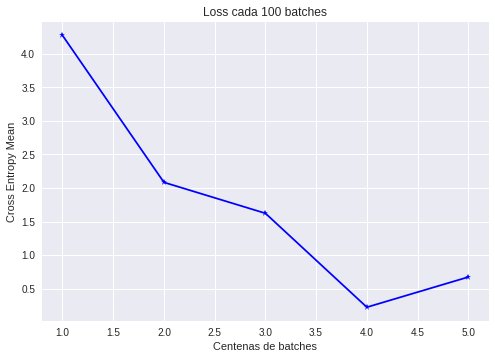

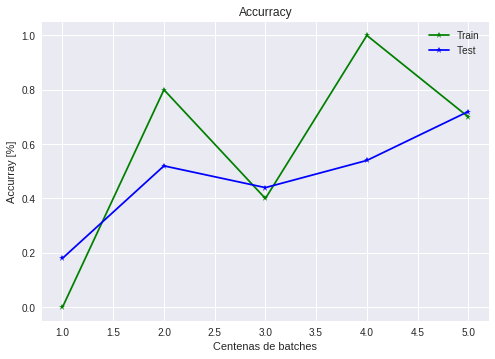

In [33]:
x_axis_res = np.linspace(1, len(loss_array_res), num=len(loss_array_res))

plt.figure()
plt.plot(x_axis, loss_array_res, 'b-*')
plt.title("Loss cada 100 batches - skResNet")
plt.xlabel("Centenas de batches")
plt.ylabel("Cross Entropy Mean")
plt.savefig('loss.pdf')

plt.figure()
plt.plot(x_axis,train_acc_res, 'g-*')
plt.plot(x_axis,test_acc_res, 'b-*')
plt.legend(["Train", "Test"])
plt.title("Accurracy - skResNet")
plt.xlabel("Centenas de batches")
plt.ylabel("Accurray [%]")
plt.savefig('accurracy.pdf')

# files.download('loss_res.pdf')
# files.download('accurracy_res.pdf')